# Construction of curated Wzy HMMs for improved annotation

## Setup

### Define file paths

In [1]:
from pathlib import Path
parent_path = Path('../')
jk_path = parent_path / 'from_JK'
jk_hmms = jk_path / 'HMM'
hmm_path = parent_path / 'hmms'
ent_path = parent_path / 'ent_test'
result_path = parent_path / 'results'

### Define functions for HMM construction

In [3]:
from pathlib import Path
from pyhmmer import __version__ as pyhmmer_version
from pyhmmer.easel import Alphabet, SequenceFile
from pyhmmer.plan7 import Builder, Background
from pytrimal import RepresentativeTrimmer, AutomaticTrimmer, Alignment, __version__ as pytrimal_version
from pyfamsa import Aligner, Sequence, __version__ as pyfamsa_version

_hmm_alphabet = Alphabet.amino()
_trim_identity_threshold = 0.5
_trim_method = 'automated1'
_id_trimmer = RepresentativeTrimmer(identity_threshold=_trim_identity_threshold)
_auto_trimmer = AutomaticTrimmer(method=_trim_method)
_aligner = Aligner()
_builder = Builder(_hmm_alphabet)
_background = Background(_hmm_alphabet)

def build_hmm(seq_file: Path, out_path: Path = hmm_path):
    protein_name = seq_file.stem
    names, seqs = [], []  # Store the MSA IDs and GappedSequences in lists for passing to Pytrimal
    for _seq in _aligner.align((Sequence(_seq.name, _seq.sequence) for _seq in SequenceFile(seq_file))):
        names.append(_seq.id), seqs.append(_seq.sequence)  # Sort IDs and seqs for pytrimal
    msa = Alignment(names, seqs, 'protein')
    desc = (f'aligned with pyfamsa v{pyfamsa_version}; trimmed with pytrimal '
            f'v{pytrimal_version} at {_trim_identity_threshold} identity threshold')
    reduced_msa = _id_trimmer.trim(msa)
    reduced_msa_pyhmmer = reduced_msa.to_pyhmmer().digitize(_hmm_alphabet)  # Trim MSA and digitize
    reduced_msa_pyhmmer.name = f'{protein_name}_reduced'.encode()  # Set the MSA (+ subsequent HMM) as cluster name
    reduced_hmm, _, _ = _builder.build_msa(reduced_msa_pyhmmer, _background)
    reduced_hmm.description = f'{desc}; built with pyhmmer v{pyhmmer_version}'.encode()
    reduced_hmm.accession = f'{protein_name}.1'.encode()
    with open(out_path / f'{protein_name}_reduced.hmm', 'wb') as f:
        reduced_hmm.write(f)
    trimmed_msa = _auto_trimmer.trim(reduced_msa)
    trimmed_msa_pyhmmer = trimmed_msa.to_pyhmmer().digitize(_hmm_alphabet)  # Trim MSA and digitize
    trimmed_msa_pyhmmer.name = f'{protein_name}_trimmed'.encode()  # Set the MSA (+ subsequent HMM) as cluster name
    trimmed_hmm, _, _ = _builder.build_msa(trimmed_msa_pyhmmer, _background)
    trimmed_hmm.description = f'{desc} and trimmed with the {_trim_method} method; built with pyhmmer v{pyhmmer_version}'.encode()
    trimmed_hmm.accession = f'{protein_name}.2'.encode()
    with open(out_path / f'{protein_name}_trimmed.hmm', 'wb') as f:
        trimmed_hmm.write(f)
    return reduced_hmm, trimmed_hmm

## Build HMMs

In [4]:
hmms = []
for i in ('A', 'B', 'C'):
    # build_hmm returns a tuple of HMMs, so we extend the list
    hmms.extend(build_hmm(jk_path / f"Wzy{i}.faa"))

### Load other HMMs

In [5]:
from pyhmmer.plan7 import HMMFile
for hmm in Path(jk_hmms).glob('*.hmm'):
    with HMMFile(hmm, db=False) as hmm:
        hmms.append(hmm.read())

### Summarise HMM metrics

In [5]:
import pandas as pd
hmm_metrics = pd.DataFrame({
    hmm.name.decode(): {
        'accession': hmm.accession.decode(),
        'description': hmm.description.decode(),
        '# sequences': hmm.nseq,
        '# effective sequences': hmm.nseq_effective,
        '# nodes': hmm.M,
        'Mean match information': hmm.mean_match_information(_background),
        'Mean match relative entropy': hmm.mean_match_relative_entropy(_background)
    } for hmm in hmms
})
hmm_metrics.to_csv(result_path / 'hmm_metrics.csv.zst', index_label='HMM metric', compression='zstd')

## Test HMMs

### Test new HMMs on ground truth sequences

In [6]:
from pyhmmer import hmmsearch
from pyhmmer.easel import SequenceFile
import pandas as pd, numpy as np

seqs, truths, quarantine = {}, [], []
for i in ['WzyA', 'WzyB', 'WzyC', 'ligases']:
    for seq in SequenceFile(jk_path / f'{i}.faa', format='fasta', alphabet=_hmm_alphabet, digital=True):
        seq_id = seq.name.decode()
        if len(seq) <= 40: quarantine.append(seq_id)
        else:
            seqs[seq_id] = seq
            truths.append(i)

print(f'Found {len(seqs)} sequences; {len(quarantine)} quarantined sequences')

truth_results = []
for hmm_hits in hmmsearch(hmms, seqs.values(), alphabet=_hmm_alphabet, background=_background, parallel='targets'):
    hits = {hit.name.decode(): hit for hit in hmm_hits}
    hmm_name = hmm_hits.query.name.decode()
    for seq_id, truth in zip(seqs.keys(), truths):
        e, s = np.nan, np.nan
        if hit := hits.get(seq_id): e, s = hit.evalue, hit.score
        truth_results.append(
            {'hmm': hmm_name, 'seq_id': seq_id, 'evalue': e, 'score': s, 'truth': truth})
truth_results = (pd.DataFrame(truth_results)
.sort_values(['seq_id', 'score'], ascending=[True, False])
.assign(
    log_e = lambda x: -np.log10(x.evalue.replace(0, 1e-300)),
    best_hmm=lambda x: np.where(
        x.groupby('seq_id')['score'].transform('max').isna(),
        "No hit",
        x.groupby('seq_id')['hmm'].transform('first')
    ),
    has_hit = lambda x: x.score > 0,
    is_best = lambda x: x.hmm == x.best_hmm,
    category = lambda x: np.select(
        [x.hmm.str.endswith('reduced'), x.hmm.str.endswith('trimmed')],
        ['Reduced', 'Trimmed'], default='Pre-existing'
    ),
    clean_hmm=lambda x: x.hmm.str.replace(r'_(reduced|trimmed)$', '', regex=True),
    truth_match = lambda x: x.clean_hmm == x.truth
))

Found 905 sequences; 0 quarantined sequences


In [7]:
print(f"Missing sequences: {set(seqs.keys()) - set(truth_results.seq_id)}")

Missing sequences: set()


Find out which HMMs performed best

In [8]:
# Identify the winner for every sequence
winning_summary = (
    truth_results
    .query('is_best == True & truth.str.startswith("Wzy")')
    .groupby('category')
    .size()
    .to_frame(name='count')
    .assign(
        percentage = lambda x: (x['count'] / x['count'].sum() * 100).round(1)
    )
)
print(winning_summary)

              count  percentage
category                       
Pre-existing     52         5.9
Reduced         836        94.1


In [9]:
evalue_stats = (
    truth_results
    .query('has_hit == True & is_best == True & truth.str.startswith("Wzy")')
    # Create a helper to identify if the HMM matches the Ground Truth cluster
    .groupby('truth_match')
    .agg(
        # For correct hits, we want the "worst" (highest) e-value that still worked
        # For off-target hits, we want the "best" (lowest) e-value to show the gap
        max_evalue=('evalue', 'max'),
        min_evalue=('evalue', 'min'),
        n_hits=('evalue', 'count')
    )
)

print(evalue_stats)
target_max = evalue_stats.loc[True, 'max_evalue']
off_target_min = evalue_stats.loc[False, 'min_evalue']

               max_evalue     min_evalue  n_hits
truth_match                                     
False        2.111423e-07  2.635911e-275      53
True         9.261409e-04   3.964044e-66     835


- To show reduced set better than trimmed set - use the figure showing the distributions of true vs false cluster hits. Change boxplot to jitter and annotate each column with number of  hits out of total number of sequences in that true or false group.

In [13]:
truth_long = (truth_results
.query('truth.str.contains("Wzy") and best_hmm != "No hit"')
.melt(id_vars=['hmm', 'truth_match', 'best_hmm'],
      value_vars=['evalue', 'score'],
      var_name='Metric', value_name='Value')
)

Plot all HMMs

/var/folders/19/34hxf43j6n311w4hcqlhddfm54ck3n/T/ipykernel_39855/4182189888.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_xtick_labels, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/19/34hxf43j6n311w4hcqlhddfm54ck3n/T/ipykernel_39855/4182189888.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_xtick_labels, rotation=45, ha='right', rotation_mode='anchor')


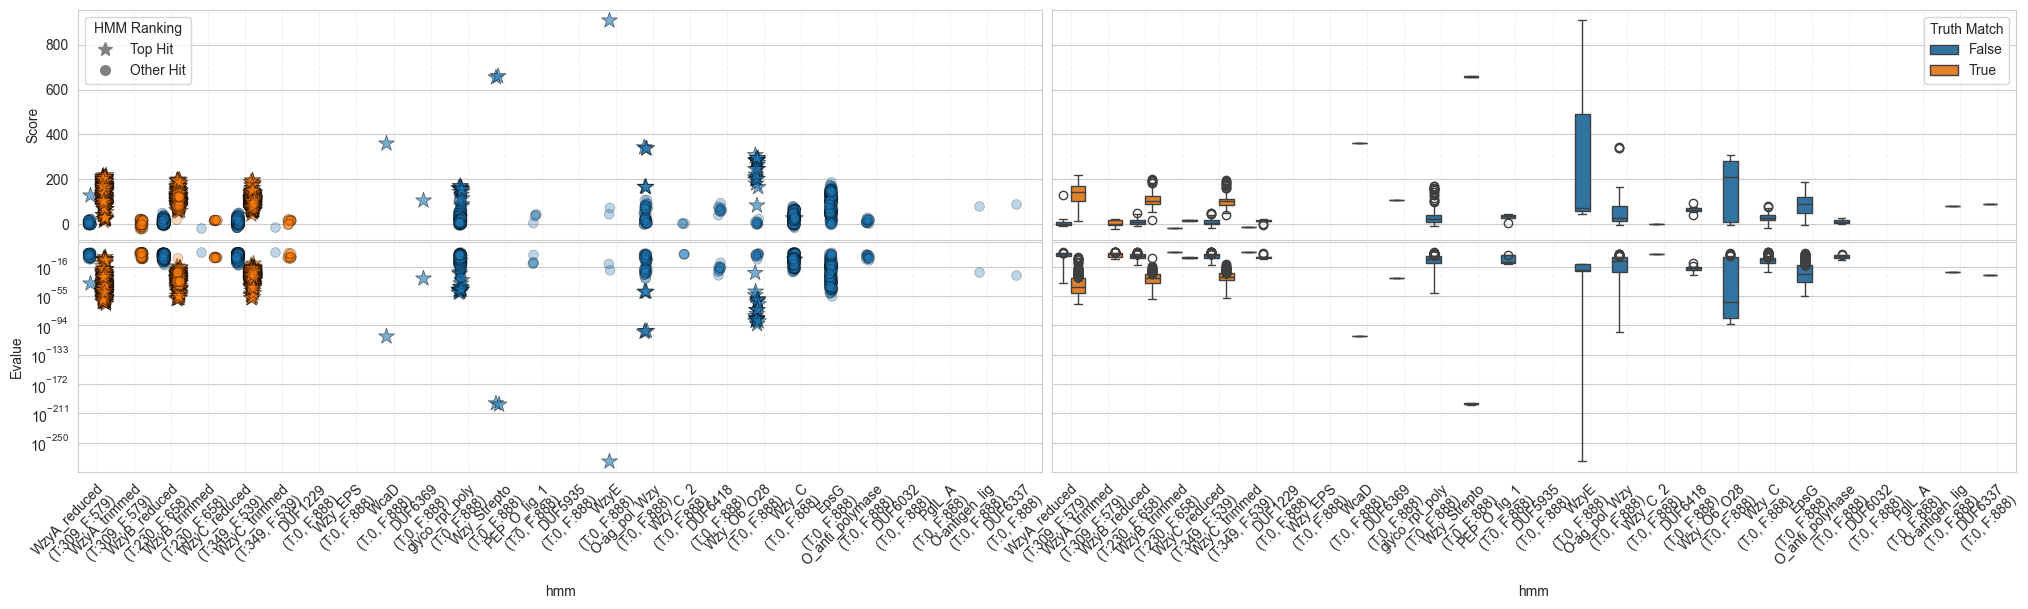

In [45]:
import seaborn as sns, matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(25, 6), sharex=True, sharey=False)
final_xtick_labels = []
for row_idx, metric in enumerate(('score', 'evalue')):
    _tmp = truth_long[truth_long.Metric == metric]
    ax_strip, ax_box = axes[row_idx]
    sns.boxplot(data=_tmp, x='hmm', y='Value', hue='truth_match', dodge=True, ax=ax_box)
    sns.stripplot(data=_tmp[_tmp.Best==True], x='hmm', y='Value', hue='truth_match',
                  alpha=0.6, jitter=True, edgecolor='black', linewidth=0.5,
                  dodge=True, ax=ax_strip, legend=False, marker='*', s=12, label='Top Hit')
    sns.stripplot(data=_tmp[_tmp.Best==False], x='hmm', y='Value', hue='truth_match',
                  alpha=0.3, jitter=True, edgecolor='black', linewidth=0.5,
                  dodge=True, ax=ax_strip, legend=False, marker='o', s=7, label='Other Hit')
    counts = pd.crosstab(_tmp.hmm, _tmp.truth_match)
    current_labels = [t.get_text() for t in ax_strip.get_xticklabels()]
    new_labels = [
        f"{l}\n(T:{counts.loc[l, True] if True in counts.columns else 0}, "
        f"F:{counts.loc[l, False] if False in counts.columns else 0})"
        for l in current_labels
    ]
    if row_idx == 1: final_xtick_labels = new_labels
    # 4. Y-axis and Legend Cleanup
    ax_strip.set_ylabel(metric.capitalize())
    ax_box.set_ylabel('')
    ax_box.tick_params(axis='y', labelleft=False, left=False)
    # Place marker legend on the top-left strip plot only
    if row_idx == 0:
        # We create proxy artists for the markers to ensure the legend looks clean
        from matplotlib.lines import Line2D
        marker_proxies = [
            Line2D([0], [0], color='gray', marker='*', linestyle='None', markersize=10, label='Top Hit'),
            Line2D([0], [0], color='gray', marker='o', linestyle='None', markersize=7, label='Other Hit')
        ]
        ax_strip.legend(handles=marker_proxies, title="HMM Ranking", loc='upper left')
        ax_box.legend(title="Truth Match", loc='upper right')
    else:
        ax_strip.get_legend().remove() if ax_strip.get_legend() else None
        ax_box.get_legend().remove() if ax_box.get_legend() else None
    # 5. Scaling and Grids
    for ax in (ax_strip, ax_box):
        ax.xaxis.grid(True, alpha=0.3, linestyle='--')
        if metric == 'evalue': ax.set_yscale('log')
        if row_idx == 1:
            ax.set_xticklabels(final_xtick_labels, rotation=45, ha='right', rotation_mode='anchor')
plt.subplots_adjust(wspace=0.01, hspace=0.01)

Plot our HMMs

/var/folders/19/34hxf43j6n311w4hcqlhddfm54ck3n/T/ipykernel_39855/3389637445.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_xtick_labels, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/19/34hxf43j6n311w4hcqlhddfm54ck3n/T/ipykernel_39855/3389637445.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_xtick_labels, rotation=45, ha='right', rotation_mode='anchor')


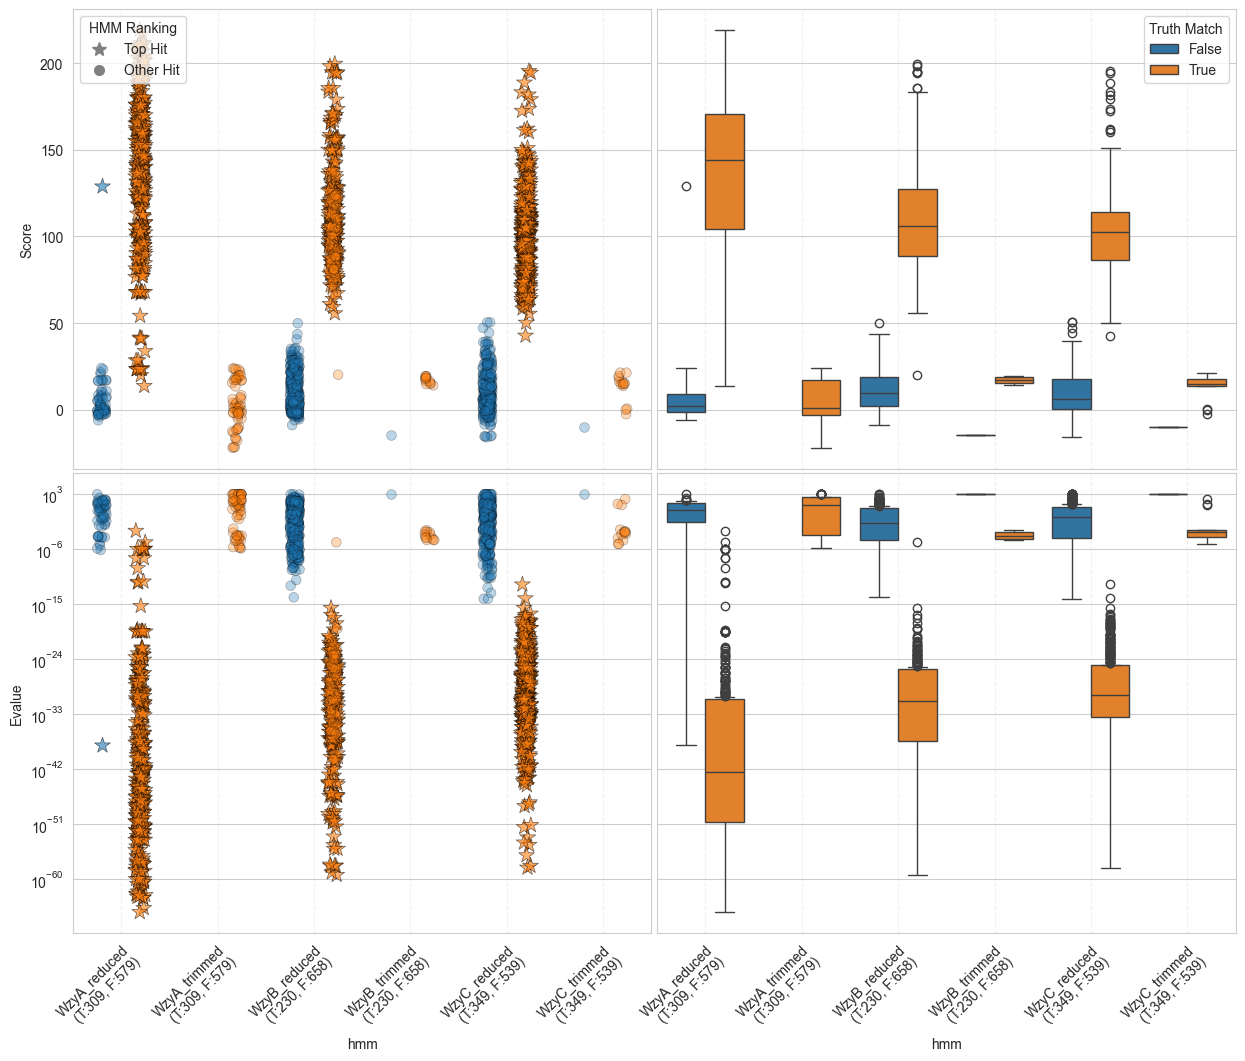

In [46]:
import re, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=False)
# To store labels for the final X-axis
final_xtick_labels = []
for row_idx, metric in enumerate(('score', 'evalue')):
    _tmp = truth_long[(truth_long.Metric == metric) & (truth_long.hmm.str.match(r'.*_(reduced|trimmed)$'))]
    ax_strip, ax_box = axes[row_idx]
    sns.boxplot(data=_tmp, x='hmm', y='Value', hue='truth_match', dodge=True, ax=ax_box)
    sns.stripplot(data=_tmp[_tmp.Best==True], x='hmm', y='Value', hue='truth_match',
                  alpha=0.6, jitter=True, edgecolor='black', linewidth=0.5,
                  dodge=True, ax=ax_strip, legend=False, marker='*', s=12, label='Top Hit')
    sns.stripplot(data=_tmp[_tmp.Best==False], x='hmm', y='Value', hue='truth_match',
                  alpha=0.3, jitter=True, edgecolor='black', linewidth=0.5,
                  dodge=True, ax=ax_strip, legend=False, marker='o', s=7, label='Other Hit')
    counts = pd.crosstab(_tmp.hmm, _tmp.truth_match)
    current_labels = [t.get_text() for t in ax_strip.get_xticklabels()]
    new_labels = [
        f"{l}\n(T:{counts.loc[l, True] if True in counts.columns else 0}, "
        f"F:{counts.loc[l, False] if False in counts.columns else 0})"
        for l in current_labels
    ]
    if row_idx == 1: final_xtick_labels = new_labels
    # 4. Y-axis and Legend Cleanup
    ax_strip.set_ylabel(metric.capitalize())
    ax_box.set_ylabel('')
    ax_box.tick_params(axis='y', labelleft=False, left=False)
    # Place marker legend on the top-left strip plot only
    if row_idx == 0:
        # We create proxy artists for the markers to ensure the legend looks clean
        from matplotlib.lines import Line2D
        marker_proxies = [
            Line2D([0], [0], color='gray', marker='*', linestyle='None', markersize=10, label='Top Hit'),
            Line2D([0], [0], color='gray', marker='o', linestyle='None', markersize=7, label='Other Hit')
        ]
        ax_strip.legend(handles=marker_proxies, title="HMM Ranking", loc='upper left')
        ax_box.legend(title="Truth Match", loc='upper right')
    else:
        ax_strip.get_legend().remove() if ax_strip.get_legend() else None
        ax_box.get_legend().remove() if ax_box.get_legend() else None
    # 5. Scaling and Grids
    for ax in (ax_strip, ax_box):
        ax.xaxis.grid(True, alpha=0.3, linestyle='--')
        if metric == 'evalue': ax.set_yscale('log')
        if row_idx == 1:
            ax.set_xticklabels(final_xtick_labels, rotation=45, ha='right', rotation_mode='anchor')
plt.subplots_adjust(wspace=0.01, hspace=0.01)

- To show that the reduced HMMs get the correct Wzy cluster - report the proportion of times that the correct HMM is the best hit for the sequences for which protein structures have been clustered.

In [49]:
print(
    truth_results
    .query('Best == True & Truth.str.contains("Wzy")')
    .agg(
        total_sequences=('truth_match', 'count'),  # Denominator: Total sequences in this cluster
        correct_top_hits=('truth_match', 'sum'),    # Numerator: How many top hits were correct
        sensitivity=('truth_match', 'mean')        # The Accuracy/Sensitivity rate
    )
    .rename(columns=lambda x: x.replace('_', ' ').capitalize())
    .to_markdown()
)

|                  |   Truth match |
|:-----------------|--------------:|
| total_sequences  | 23114         |
| correct_top_hits |  1778         |
| sensitivity      |     0.0769231 |


In [47]:
print(
    truth_results
    .query('Best == True & Truth.str.contains("Wzy") & hmm.str.contains("(reduced|trimmed)")')
    .agg(
        total_sequences=('truth_match', 'count'),  # Denominator: Total sequences in this cluster
        correct_top_hits=('truth_match', 'sum'),    # Numerator: How many top hits were correct
        sensitivity=('truth_match', 'mean')        # The Accuracy/Sensitivity rate
    )
    .rename(columns=lambda x: x.replace('_', ' ').capitalize())
    .to_markdown()
)

|                  |   Truth match |
|:-----------------|--------------:|
| total_sequences  |    836        |
| correct_top_hits |    835        |
| sensitivity      |      0.998804 |


/var/folders/19/34hxf43j6n311w4hcqlhddfm54ck3n/T/ipykernel_39855/1494833119.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  .query('Best == True & Truth.str.contains("Wzy") & hmm.str.contains("(reduced|trimmed)")')


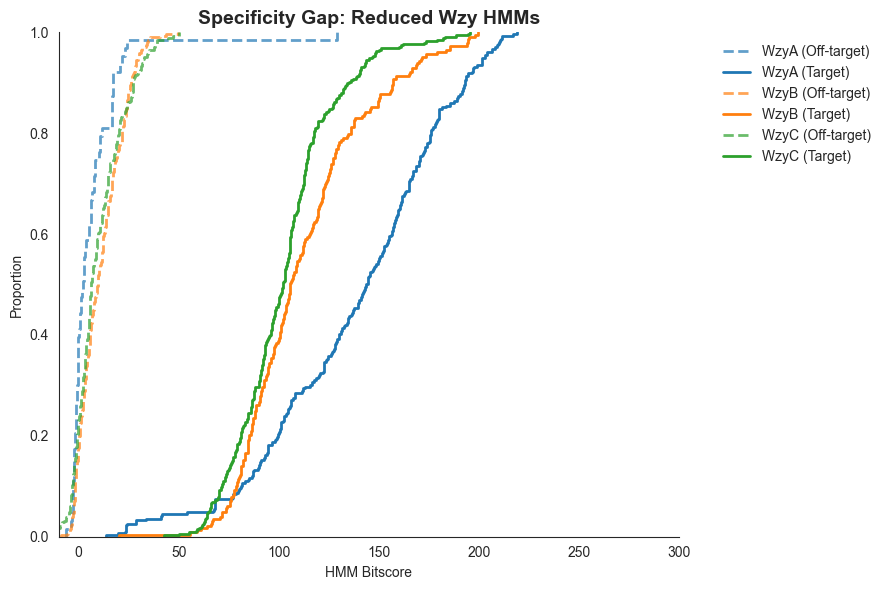

In [84]:
# 1. Filter to just the essential comparison for the main story
final_plot_df = (
    truth_results
    .dropna(subset=['score'])
    .query('category == "Reduced"') # Focus only on your new models for clarity
    .query('truth in ["WzyA", "WzyB", "WzyC"]') # Only show the key Wzy clusters
)

plt.figure(figsize=(9, 6))
sns.set_style("white")

# 2. Dynamic Palette for the 3 main clusters
palette = {"WzyA": "#1f77b4", "WzyB": "#ff7f0e", "WzyC": "#2ca02c"}

for (hmm, match), group in final_plot_df.groupby(['clean_hmm', 'truth_match']):
    label = f"{hmm} ({'Target' if match else 'Off-target'})"

    # HIGHLIGHT: Make Targets thick and solid, Off-targets thin and very faint
    linewidth = 2.0 if match else 2.0
    linestyle = '-' if match else '--'
    alpha = 1.0 if match else 0.7

    sns.ecdfplot(
        data=group, x='score', label=label,
        color=palette.get(hmm, "grey"), # Use grey for any non-Wzy clusters
        ls=linestyle, lw=linewidth, alpha=alpha
    )

plt.xlim(-10, 300) # Zoom in on the relevant bitscore range
plt.title("Specificity Gap: Reduced Wzy HMMs", fontsize=14, fontweight='bold')
plt.xlabel("HMM Bitscore")
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

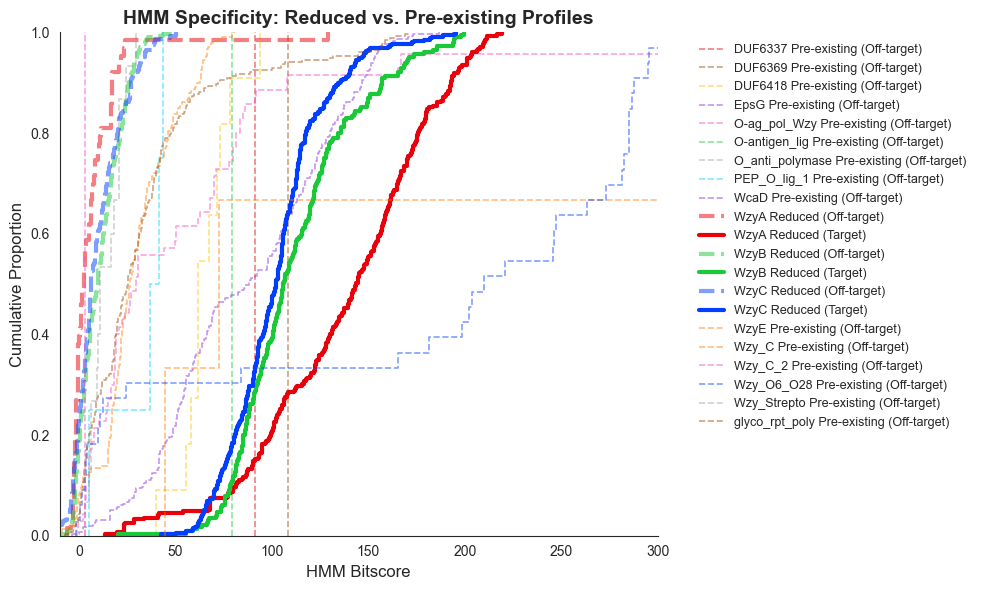

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter to the core comparison
final_comparison_df = (
    truth_results
    .dropna(subset=['score'])
    .query('category in ["Reduced", "Pre-existing"]') # Drop Trimmed
    .query('truth in ["WzyA", "WzyB", "WzyC"]')      # Focus on key clusters
)

plt.figure(figsize=(10, 6))
sns.set_style("white")

# 2. Dynamic Palette based on your unique HMMs
unique_hmms = final_comparison_df['clean_hmm'].unique()
colors = sns.color_palette("bright", len(unique_hmms))
palette = dict(zip(unique_hmms, colors))

# 3. Plotting loop
for (hmm_cluster, category, match), group in final_comparison_df.groupby(['clean_hmm', 'category', 'truth_match']):
    is_target = "Target" if match else "Off-target"
    label = f"{hmm_cluster} {category} ({is_target})"

    # Style Logic
    # Target = Solid, Off-target = Dashed
    linestyle = '-' if match else '--'

    # Reduced = Thick (Your work), Pre-existing = Thin (Baseline)
    linewidth = 3.0 if category == "Reduced" else 1.2

    # Alpha: Targets are bold, Off-targets are highly visible but distinct
    alpha = 1.0 if match else 0.5

    sns.ecdfplot(
        data=group,
        x='score',
        label=label,
        color=palette[hmm_cluster],
        ls=linestyle,
        lw=linewidth,
        alpha=alpha
    )

# 4. Publication-Ready Aesthetics
plt.xlim(-10, 300) # Maintain the zoom you liked
plt.title("HMM Specificity: Reduced vs. Pre-existing Profiles", fontsize=14, fontweight='bold')
plt.xlabel("HMM Bitscore", fontsize=12)
plt.ylabel("Cumulative Proportion", fontsize=12)
sns.despine()

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

### Test new HMMs on _Enterobacterales_
Wzy sequences from cps/KPS clusters defined in Holt et al., ISME 2022.

In [68]:
import requests, io
from pyhmmer import hmmsearch
from pyhmmer.easel import SequenceFile, Alphabet, GeneticCode
import pandas as pd, numpy as np

url = (f'https://raw.githubusercontent.com/rmostowy/'
       f'fastKaptive/refs/heads/master/reference-db/'
       f'cps/00_extended/database/genes.fa')
seqs, quarantine = {}, []
with requests.Session() as session:
    response = session.get(url)
    response.raise_for_status()  # This will raise an error for bad responses (4xx or 5xx)
    # Wrap the downloaded content (bytes) in a file-like object
    for seq in SequenceFile(io.BytesIO(response.content), format='fasta', alphabet=Alphabet.dna(), digital=True
                            ).read_block().translate(GeneticCode(11)):
        seq_id = seq.name.decode()
        if len(seq) <= 40: quarantine.append(seq_id)
        else: seqs[seq_id] = seq

print(f'Found {len(seqs)} sequences; {len(quarantine)} quarantined sequences')

ent_results = []
for hmm_hits in hmmsearch(hmms, seqs.values(), alphabet=_hmm_alphabet, background=_background, parallel='targets'):
    hits = {hit.name.decode(): hit for hit in hmm_hits}
    hmm_name = hmm_hits.query.name.decode()
    for seq_id in seqs.keys():
        e, s = np.nan, np.nan
        if hit := hits.get(seq_id): e, s = hit.evalue, hit.score
        ent_results.append(
            {'hmm': hmm_name, 'seq_id': seq_id, 'evalue': e, 'score': s})

ent_results = (
    pd.DataFrame(ent_results)
    .pipe(lambda df: df.join(
        df['seq_id'].str.extract(r'(?P<Species>\w+)-(?P<Locus>\w+)__(?P<Gene>\w+)')
    ))
    .assign(
        best_hmm=lambda x: np.where(
            x.groupby('seq_id')['score'].transform('max').isna(),
            "No hit",
            x.groupby('seq_id')['hmm'].transform('first')
        ),
        has_hit = lambda x: x.score > 0,
        is_best = lambda x: x.hmm == x.best_hmm,
        category = lambda x: np.select(
            [x.hmm.str.endswith('reduced'), x.hmm.str.endswith('trimmed')],
            ['Reduced', 'Trimmed'], default='Pre-existing'
        ),
        clean_hmm=lambda x: x.hmm.str.replace(r'_(reduced|trimmed)$', '', regex=True)
    )
)

Found 16281 sequences; 28 quarantined sequences


- To highlight the broad applicability and further showcase the sensitivity of the reduced HMMs report the proportion of K loci with a hit to any reduced HMM among the Enterobacteriales set, compare to the proportion of K loci with any hot to the pre-exisiting HMMs

In [42]:
ent_locus_detected = (
ent_results
    .groupby(['category', 'Species', 'Locus'])['has_hit']
    .max()
    .reset_index()
)

# 2. Generate the Top-Level (Non-Species) Summary
top_level_summary = (
    ent_locus_detected
    .groupby('HMM_Set')
    .agg(
        Total_K_Loci=('has_hit', 'count'),
        Loci_Detected=('has_hit', 'sum'),
        Proportion_Detected=('has_hit', 'mean')
    )
)
print(top_level_summary.to_markdown())

| HMM_Set      |   Total_K_Loci |   Loci_Detected |   Proportion_Detected |
|:-------------|---------------:|----------------:|----------------------:|
| Pre-existing |            994 |             756 |             0.760563  |
| Reduced      |            994 |             902 |             0.907445  |
| Trimmed      |            994 |              60 |             0.0603622 |


## HMMs against Kaptive Wzy

In [22]:
from pyhmmer.easel import TextSequence
from kaptive.database import load_database
seqs, quarantine = {}, []
for species in ('kpsc', 'ab'):
    for seq_id, gene in load_database(f'{species}_k', extract_translations=True).genes.items():
        seq_id = f'{species}-{seq_id}'
        if len(gene.protein_seq) <= 40: quarantine.append(seq_id)
        else:
            seqs[seq_id] = TextSequence(name=seq_id.encode(), sequence=str(gene.protein_seq)).digitize(_hmm_alphabet)
print(f'Found {len(seqs)} sequences; {len(quarantine)} quarantined sequences')
kaptive_results = []
for hmm_hits in hmmsearch(hmms, seqs.values(), alphabet=_hmm_alphabet, background=_background, parallel='targets'):
    hits = {hit.name.decode(): hit for hit in hmm_hits}
    hmm_name = hmm_hits.query.name.decode()
    for seq_id in seqs.keys():
        e, s = np.nan, np.nan
        if hit := hits.get(seq_id): e, s = hit.evalue, hit.score
        kaptive_results.append(
            {'hmm': hmm_name, 'seq_id': seq_id, 'evalue': e, 'score': s})
kaptive_results = pd.DataFrame(kaptive_results)
kaptive_results[['Species', 'Locus', 'Gene pos', 'Gene']] = kaptive_results.seq_id.str.extract(r'^(.+)-(.+)_(\d+)(?:_(.+))?$').values

Found 8440 sequences; 3 quarantined sequences


In [24]:
kaptive_best = (
    kaptive_results
    .pivot(columns='hmm', values='score', index='seq_id')
    .idxmax(axis=1) # Returns the column name of the max score
    .fillna("No hit")
).rename('best_hmm')

/var/folders/19/34hxf43j6n311w4hcqlhddfm54ck3n/T/ipykernel_47932/483988478.py:4: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  .idxmax(axis=1) # Returns the column name of the max score


In [32]:
import pandas as pd
import numpy as np

# Define our classification logic
conditions = [
    kaptive_results.hmm.str.endswith('reduced'),
    kaptive_results.hmm.str.endswith('trimmed')
]
choices = ['Reduced', 'Trimmed']

kaptive_validation = (
    kaptive_results
    .assign(
        # 1. Bucket into three distinct teams
        HMM_Set = lambda x: np.select(conditions, choices, default='Pre-existing'),
        is_wzy = lambda x: x.Gene.str.contains('wzy', na=False),
        has_hit = lambda x: x.score > 0
    )
    # 2. Collapse to Sequence-level: Did this "Team" find this sequence?
    .groupby(['HMM_Set', 'seq_id', 'is_wzy'])['has_hit']
    .max()
    .reset_index()
    # 3. Apply Confusion Matrix logic
    .assign(
        TP = lambda x: x.is_wzy & x.has_hit,
        TN = lambda x: ~x.is_wzy & ~x.has_hit,
        FP = lambda x: ~x.is_wzy & x.has_hit,
        FN = lambda x: x.is_wzy & ~x.has_hit
    )
    # 4. Final Aggregation
    .groupby('HMM_Set')
    .agg(
        Total_Seqs=('seq_id', 'count'),
        TP=('TP', 'sum'),
        FP=('FP', 'sum'),
        TN=('TN', 'sum'),
        FN=('FN', 'sum')
    )
    .assign(
        Total_Wzy = lambda x: x.TP + x.FN,
        Sensitivity = lambda x: x.TP / x.Total_Wzy,
        Specificity = lambda x: x.TN / (x.TN + x.FP)
    )
    # Reorder columns for the manager's report
    [['Total_Seqs', 'Total_Wzy', 'TP', 'FN', 'FP', 'TN', 'Sensitivity', 'Specificity']]
)

print(kaptive_validation.to_markdown())

| HMM_Set      |   Total_Seqs |   Total_Wzy |   TP |   FN |   FP |   TN |   Sensitivity |   Specificity |
|:-------------|-------------:|------------:|-----:|-----:|-----:|-----:|--------------:|--------------:|
| Pre-existing |         8440 |         374 |  320 |   54 |   22 | 8044 |     0.855615  |      0.997273 |
| Reduced      |         8440 |         374 |  368 |    6 |   48 | 8018 |     0.983957  |      0.994049 |
| Trimmed      |         8440 |         374 |   29 |  345 |    1 | 8065 |     0.0775401 |      0.999876 |
